In [ ]:
## Clone GitHub Repo to Colab 
!git clone https://github.com/anujanand6/Sentiment-Analysis-of-Drug-Reviews.git

Cloning into 'Sentiment-Analysis-of-Drug-Reviews'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59
Unpacking objects: 100% (59/59), done.
Checking out files: 100% (14/14), done.


# Sentiment Ananlysis of Drug Reviews

Patients give reviews for a drug based on the efficacy and their experience using the drug. The objective of this project is to assign a sentiment (positive or negative) to an unlabeled review utilizing already labelled reviews. Assigning a sentiment would help the brand understand what is working for their drug and what is not by looking at the competitor data.

Key concepts implemented: <br>
1. Expolatory Data Analysis
2. Tokenization and Word Count
3. Count Vectorization & TF-IDF
4. NMF & LDA
5. GloVe
6. ELMo
7. DistilBERT
8. BioBERT
9. Performance comparison of Base English model and scispaCy model.
10. Sentiment Classification using Linar SVC, RBF SVC, Gaussian Naive Bayes

## **NOTE**: 

### 1. Since we have implemented large models like BERT and BioBERT, please run on GPU.

### 2. Till the cell block called 'Data Reduction', please run the notebook as it is. Then you can choose to reduce the size of the data, if needed.

## Library Installations and System Setup

In addition to the spaCy's Base English model, we also used the ScispaCy model called **en_ner_bc5cdr_md**. This is a spaCy NER model trained on the BC5CDR corpus. This model is mainly used for the purpose of Disease-Chemical relation extraction. Since our dataset comprises a plethora of biomedical terms, this seemd to be a good option.

In [ ]:
# A spaCy NER model trained on the BC5CDR corpus
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz

import en_ner_bc5cdr_md
# Load SciscpaCy model
nlp_sci = en_ner_bc5cdr_md.load()

     |████████████████████████████████| 70.1MB 41kB/s 
  Created wheel for en-ner-bc5cdr-md: filename=en_ner_bc5cdr_md-0.2.4-cp36-none-any.whl size=70531467 sha256=50d6a85b05667df9c749a69ade438573e00790e027a999b9b51b36f4134d00a4
  Stored in directory: /root/.cache/pip/wheels/e1/06/4f/75676083b8afcd820050011e7c88bfbae8b42c6f36a3aca6f8
Successfully built en-ner-bc5cdr-md


In [ ]:
# setup
import sys
import subprocess
import pkg_resources
import re

required = {'spacy', 'scikit-learn', 'numpy', 
            'pandas', 'torch', 'matplotlib',
            'transformers', 'allennlp==0.9.0'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import spacy
import numpy as np
import pandas as pd
import random

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import pickle

import matplotlib
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

from allennlp.commands.elmo import ElmoEmbedder

import transformers
from transformers import BertModel, BertTokenizer
from transformers import DistilBertModel, DistilBertTokenizer

import torch
# GPU Device
device = torch.device("cuda:0") 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load Base English model
from spacy.lang.en import English
en = English()

## Load Data

In [ ]:
# Change to required path
file_path = "/content/Sentiment-Analysis-of-Drug-Reviews/Data Files"

train_data = pd.read_csv(file_path + "/drugsComTrain_raw.csv", parse_dates=["date"])
test_data = pd.read_csv(file_path + "/drugsComTest_raw.csv", parse_dates=["date"])

In [ ]:
print(train_data.shape)
print(test_data.shape)

(161297, 7)
(53766, 7)


In [ ]:
# Join both train and test data for easy EDA
data = train_data.append(test_data)
data.shape

(215063, 7)

We have more than 200k reviews in our whole corpus.

## Create Sentiment Label

We create the dependent variable called 'sentiment' based on the ratings of the reviews.

We set the sentiment as: <br>
Negative if the rating is between 1 to 5 <br>
Positive if the rating is between 6 to 10



In [ ]:
# Add sentiment labels based on rating
# 1,2,3,4,5 - Negative
# 6,7,8,9,10 - Positive

data["sentiment"] = data["rating"].apply(lambda rating: 'positive' if  rating >= 6  
                                         else 'negative')

## Expolatory Data Analysis on Full Dataset

In [ ]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,negative
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,positive


Features in our dataset: <br>

*  Unique ID   : a unique ID for each drug
*  Drug Name   : name of the drug
*  Condition   : medical condition that the drug is used to treat.
*  Review      : patients’ review of the drug
*  Rating      : overall scoring of the drug on a scale of 1 to 10
*  Date        : the date on which the review was recorded
*  usefulCount : this is a count of how many people found this review to be useful.

In [ ]:
print(data.isnull().sum())

uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
sentiment         0
dtype: int64


There are about 1200 missing values which we will remove later on.

In [ ]:
# Split data into positive and negative corpus
pos = data[data["sentiment"] == "positive"]
neg = data[data["sentiment"] == "negative"]

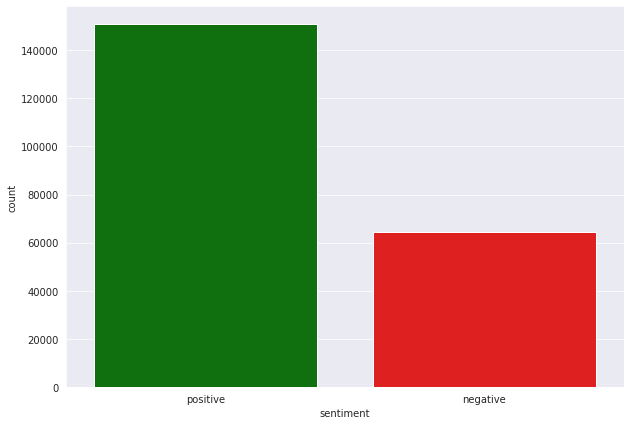

In [ ]:
# Count of each label
rcParams['figure.figsize'] = 10, 7
sns.set_style("darkgrid")
sns.countplot(data.sentiment, palette=["green", "red"])

This is a clear case of class imbalance.

At this point, undersampling the positive reviews is an option, however we want to move ahead with first selecting the top 'N' conditons for the purpose of this analysis (you'll see further in the code) and then again check for the pos/neg distribution.



Let's look at the distribution of the sentiment across conditions and drugs. 

In [ ]:
print("Number of unique conditions/diseases: ", data.condition.unique().shape[0])

Number of unique conditions/diseases:  917


That's a lot of conditions!! Let's plot the number of reviews for the top 20 conditions.

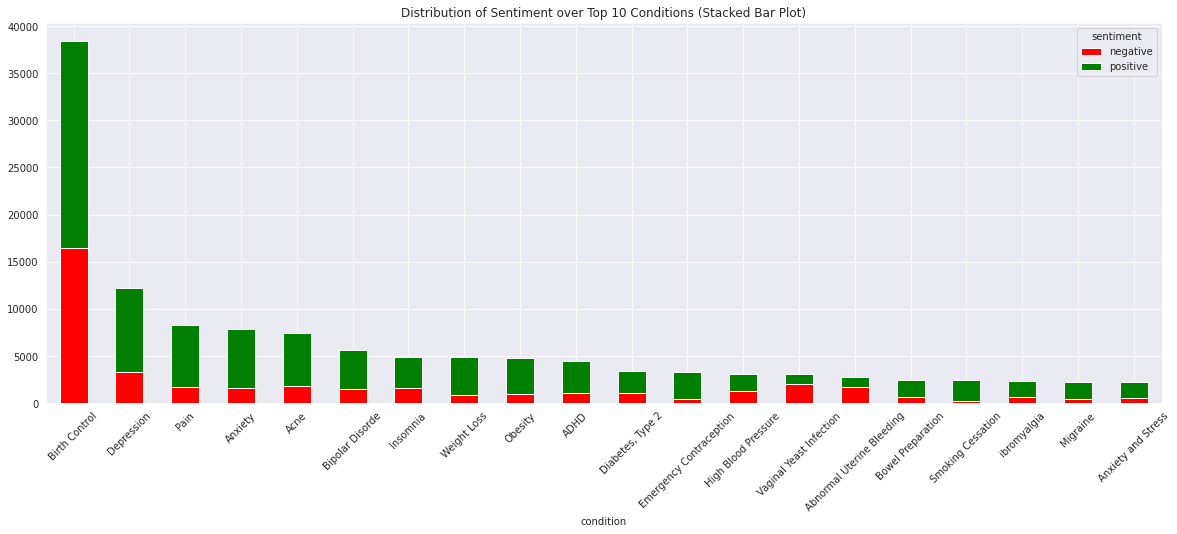

In [ ]:
# stacked bar plot
#Get values from the group and categories
N = 20

conditions_list = list(data['condition'].value_counts().sort_values(ascending=False)[0:N].index)
condition_count = data[data['condition'].isin(conditions_list)].groupby(['condition'])['sentiment'].value_counts()

colors = [ 'red', 'green']

rcParams['figure.figsize'] = 20, 7
s_sort = condition_count.groupby(level=[0]).sum().sort_values(ascending=False)
df_sorted = condition_count.reindex(index=s_sort.index, level=0)
df_sorted.unstack().plot.bar(stacked=True, color=colors, title="Distribution of Sentiment over Top 10 Conditions (Stacked Bar Plot)", rot=45)


Birth control seems to have the highest number of reviews followed by depression. Including these conditions to the dataset might induce some bias which we will tackle later on.

In almost all conditions there seem to be more positive reviews than negative ones.

Let's visualize the above after taking out birth control.

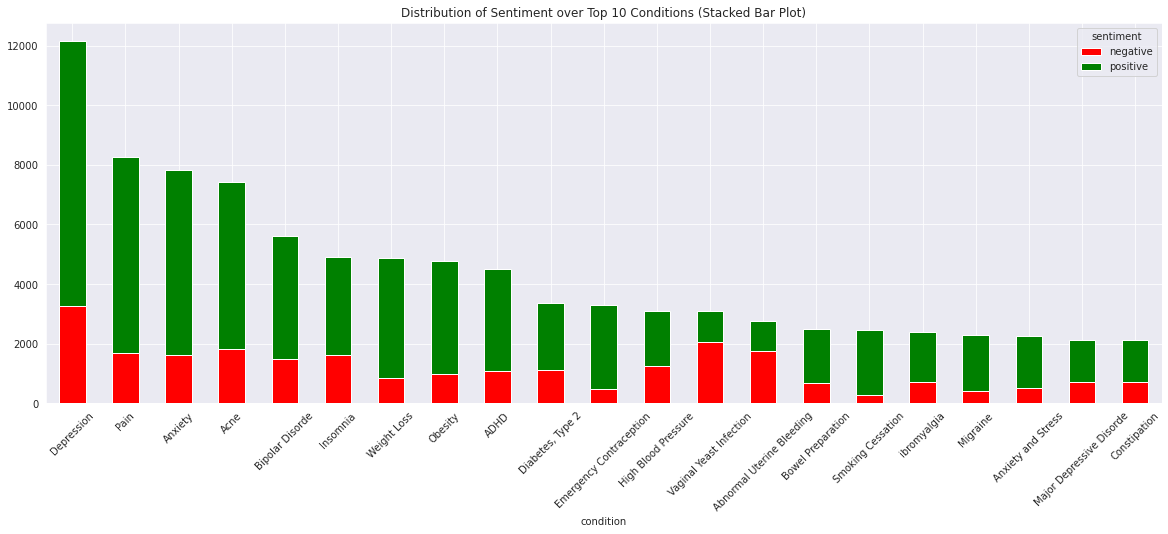

In [ ]:
# stacked bar plot
#Get values from the group and categories
N = 20

conditions_list = list(data['condition'].value_counts().sort_values(ascending=False)[1:N+2].index)
condition_count = data[data['condition'].isin(conditions_list)].groupby(['condition'])['sentiment'].value_counts()

colors = [ 'red', 'green']

rcParams['figure.figsize'] = 20, 7
s_sort = condition_count.groupby(level=[0]).sum().sort_values(ascending=False)
df_sorted = condition_count.reindex(index=s_sort.index, level=0)
df_sorted.unstack().plot.bar(stacked=True, color=colors, title="Distribution of Sentiment over Top 10 Conditions (Withoout Birth Control)", rot=45)

In [ ]:
print("Number of reviews present for bottom 15 conditions:", "\n")
data['condition'].value_counts().sort_values(ascending=True)[0:15]

Number of reviews present for bottom 15 conditions: 



Paragonimus westermani, Lung Fluke              1
Neurotic Depression                             1
Cerebrovascular Insufficiency                   1
92</span> users found this comment helpful.     1
Systemic Candidiasis                            1
AV Heart Block                                  1
54</span> users found this comment helpful.     1
Hodgkin's Lymphoma                              1
Hypercalcemia                                   1
63</span> users found this comment helpful.     1
Q Feve                                          1
Diagnostic Bronchograms                         1
Hydrocephalus                                   1
121</span> users found this comment helpful.    1
38</span> users found this comment helpful.     1
Name: condition, dtype: int64

These conditions do not help us since they just have one review.

In [ ]:
print("Number of conditions starting with '<span>' that have no meaning: ", 
      data.condition[data.condition.str.contains("</span>", na=True)].count())

There seem to be around 1171 wrong entries like '40 < /span> users found this comment helpful.' under the conditions column which do not make sense. We will remove them in the data preprocessing step.

Understanding the distribution of the drugs among the conditons is also important for our usecase so that we do not end up taking conditions with many drugs.

In [ ]:
condition_dn = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="blue")
plt.xlabel("Condition", fontsize = 20)
plt.ylabel("Number of Drugs", fontsize = 20)
plt.title("The Number of Drugs per Condition (top 20)", fontsize = 20)

As we would expect, generic conditions like pain and birth control seem to have a high number of reviews.

Let's see the same thing for the bottom 20 conditions.

In [ ]:
condition_dn = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=True)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="blue")
plt.xlabel("Condition", fontsize = 20)
plt.ylabel("Number of Drugs", fontsize = 20)
plt.title("The Number of Drugs per Condition (bottom 20)", fontsize = 20)

There are many conditions with just one drug. These don't help with our usecase so let's remove them in the data preprocessing as well.

## Data Preprocessing

In [ ]:
# Drop missing rows
data = data.dropna(axis=0)

Since the features 'date' and 'usefulCount' were not useful for our problem statement, we decided to drop them.

In [ ]:
# Drop date and useful count
data = data.drop(['date', 'usefulCount'], axis = 1) 

In [ ]:
# Remove the anomalies
data = data[~data.condition.str.contains("</span>")]
data = data[~data.condition.str.contains("Not Listed / Othe")]

In [ ]:
print("Size of data after preprocessing: ", data.shape)

Size of data after preprocessing:  (212106, 6)


## Data Reduction

There are three ways we could do this:

1) Random sampling

2) K means clustering and then choosing a subset of data from each clusters.

3) Reduce the number of conditons

Unfortuntely due to the huge size of our data, we could not implement K-Means clustering and with random sampling we may lose some important information. 

So we decided to go ahead with the third option of reducing the number of conditions.



Looking at the top conditons with most reviews, the most intuitive choice would be to go with top 'N' conditions. <br>
However we made a few decisions to support the choice of going with the below and here's why - <br>
- Removed conditons with less than 10 reviews.
- Removed conditions which are very generic (Ex: Cough, Fever, Pain) even though they had more reviews than the below 4. <br>
- To ensure each condition we select has almost comparable number of reviews. (Ex: removed birth control since it had too high number of reviews).
- It should also have a decent distribution of positive and negative reviews.

The Chosen Conditions:
1. Diabetes, Type 2
2. Bipolar Disorder
3. ADHD
4. High Blood Pressure



The below code implements the steps mentioned above.

In [ ]:
# Remove conditions that are generic or have a high number of reviews
data = data[~data.condition.isin(['Birth Control','Anxiety' ,'Depression', 'Pain', 'Fever', 'Cough'])]
data.shape

(144225, 6)

In [ ]:
# Remove conditions with with less than 2000 reviews
df_conditions = list(data['condition'].value_counts()[data['condition'].value_counts()<=2000].index)
data = data[~data['condition'].isin(df_conditions)]
data.shape

(63723, 6)

In [ ]:
print("Number of unique conditions after removing above conditions: ", data['condition'].unique().shape[0])

Number of unique conditions after removing above conditions:  18


This has decreased the number of unique conditions from 917 to 18.

In [ ]:
# Remove drugs with with less than 10 reviews
df_drugs = list(data['drugName'].value_counts()[data['drugName'].value_counts()<10].index)
data = data[~data['drugName'].isin(df_drugs)]
data.shape

(62327, 6)

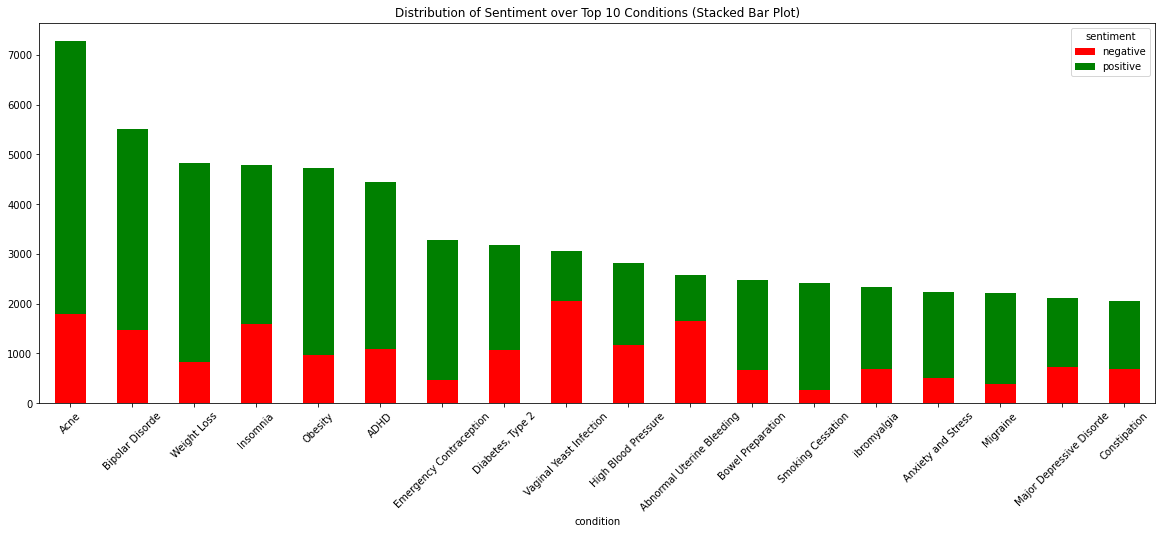

In [ ]:
# stacked bar plot
#Get values from the group and categories
N = 20

conditions_list = list(data['condition'].value_counts().sort_values(ascending=False)[0:N].index)
condition_count = data[data['condition'].isin(conditions_list)].groupby(['condition'])['sentiment'].value_counts()

colors = [ 'red', 'green']

rcParams['figure.figsize'] = 20, 7
s_sort = condition_count.groupby(level=[0]).sum().sort_values(ascending=False)
df_sorted = condition_count.reindex(index=s_sort.index, level=0)
df_sorted.unstack().plot.bar(stacked=True, color=colors, title="Distribution of Sentiment over Top 10 Conditions (Stacked Bar Plot)", rot=45)

Subset the data based on the chosen conditions

In [ ]:
# List of chosen conditions
condition_list = ['Bipolar Disorde', 'ADHD', 'Diabetes, Type 2', 'High Blood Pressure']

data_subset = data[data["condition"].isin(condition_list)]
data_subset.shape

(15965, 6)

## To run a simpler version of the notebook, please run the below code. If not, please skip this step.

This will reduce the number of observations to 2000.

In [ ]:
data_subset = data_subset.sample(n=2000, random_state=123)
data_subset.shape

(2000, 6)

## Expolatory Data Analysis on Reduced Dataset

In [ ]:
conditions_count = data_subset.condition.unique().shape[0]
print("Number of unique conditions in subset data: ", conditions_count)

Number of unique conditions in subset data:  4


In [ ]:
print("Number of unique drugs: ", data_subset.drugName.unique().shape[0])

Number of unique drugs:  187


Text(0.5, 1.0, 'Distribution of Sentiment Labels')

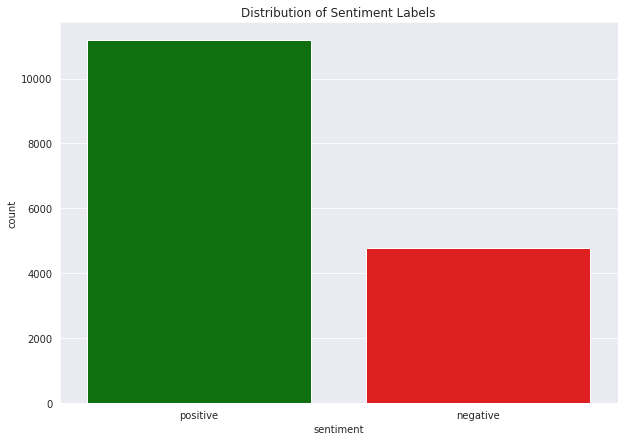

In [ ]:
# Count of each label
rcParams['figure.figsize'] = 10, 7
sns.set_style("darkgrid")
sns.countplot(data_subset.sentiment, palette=["green", "red"]).set_title("Distribution of Sentiment Labels")

Like mentioned earlier, this imbalance in our dataset is handled during modeling!

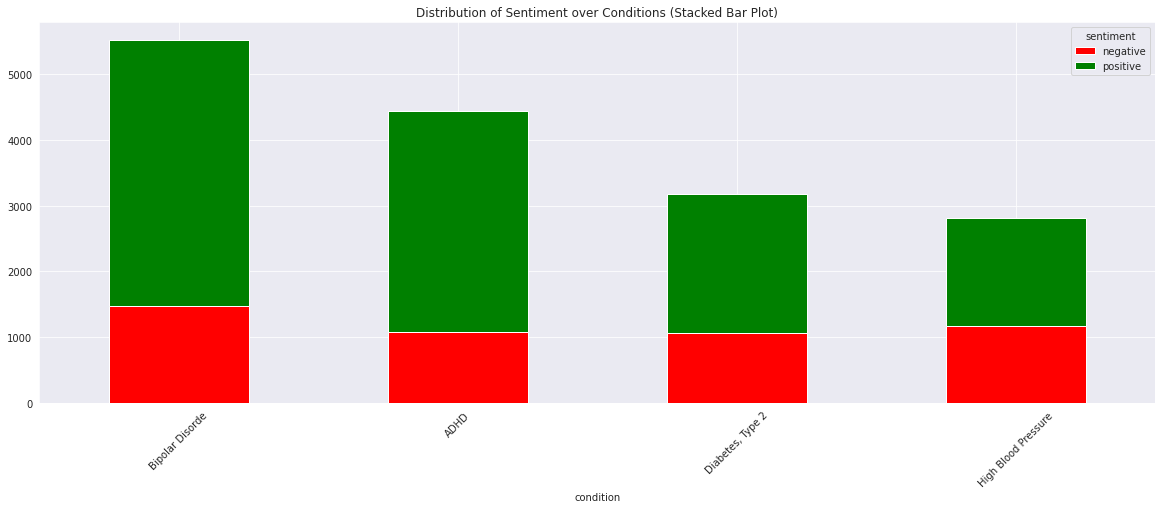

In [ ]:
# stacked bar plot

conditions_list = list(data_subset['condition'].value_counts().sort_values(ascending=False).index)
condition_count = data_subset[data_subset['condition'].isin(conditions_list)].groupby(['condition'])['sentiment'].value_counts()

colors = [ 'red', 'green']

rcParams['figure.figsize'] = 20, 7
s_sort = condition_count.groupby(level=[0]).sum().sort_values(ascending=False)
df_sorted = condition_count.reindex(index=s_sort.index, level=0)
df_sorted.unstack().plot.bar(stacked=True, color=colors, title="Distribution of Sentiment over Conditions (Stacked Bar Plot)", rot=45)

There isn't a big difference between number of reviews for each condition.

Text(0.5, 1.0, 'The Number of Drugs per Condition')

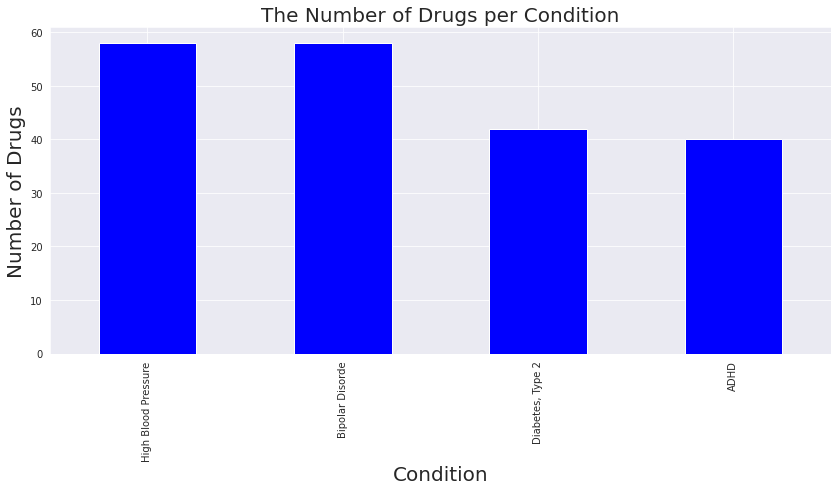

In [ ]:
condition_dn = data_subset.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn.plot(kind="bar", figsize = (14,6), fontsize = 10,color="blue")
plt.xlabel("Condition", fontsize = 20)
plt.ylabel("Number of Drugs", fontsize = 20)
plt.title("The Number of Drugs per Condition", fontsize = 20)

All the conditions have almost the same number of reviews and unique drugs. This will help us to indentify the most and least favourable drugs in each condition.

## Tokenizer Function

In [ ]:
# Advanced Tokenizer

def adv_tokenizer(doc, model=en, 
                  replace_entities=False, 
                  stop_words=False, 
                  lowercase=True, 
                  alpha_only=True, 
                  lemma=True):
    """Full tokenizer with flags for processing steps
    replace_entities: If True, replaces with entity type
    stop_words: If False, removes stop words
    lowercase: If True, lowercases all tokens
    alpha_only: If True, removes all non-alpha characters
    lemma: If True, lemmatizes words
    """
    parsed = model(doc)
    # token collector
    tokens = []
    # index pointer
    i = 0
    # entity collector
    ent = ''
    for t in parsed:
        # only need this if we're replacing entities
        if replace_entities:
            # replace URLs
            if t.like_url:
                tokens.append('URL')
                continue
            # if there's entities collected and current token is non-entity
            if (t.ent_iob_=='O')&(ent!=''):
                tokens.append(ent)
                ent = ''
                continue
            elif t.ent_iob_!='O':
                ent = t.ent_type_
                continue
        # only include stop words if stop words==True
        #if (t.is_stop) & (not stop_words):
        if (t.is_stop):
            continue
        # only include non-alpha is alpha_only==False
        if (not t.is_alpha)&(alpha_only):
            continue
        if lemma:
            t = t.lemma_
        else:
            t = t.text
        if lowercase:
            t.lower() 
        tokens.append(t)   
    return tokens

## Tokenization & Word Count


### Split Positive and Negative reviews for Word Counts

In [ ]:
reviews_pos = data_subset[data_subset["sentiment"]=="positive"].review
reviews_neg = data_subset[data_subset["sentiment"]=="negative"].review

reviews = reviews_pos.append(reviews_neg)

### Tokenization Design

Function to return the top N tokens using Count Vectorizer

In [ ]:
# Function to return the top N tokens using Count Vectorizer
def top_N_words(text, N=10, model=en, replace_entities=False, stopwords=False, lowercase=True, alpha_only=True, lemma=True, min_df=1, max_df=1.0, ngram=1):
  # running this on negative reviews
  cv = CountVectorizer(tokenizer=lambda text: adv_tokenizer(text, model=model, 
                                                            lemma=lemma, 
                                                            replace_entities=replace_entities,
                                                            lowercase=lowercase, 
                                                            stop_words=stopwords,
                                                            alpha_only=alpha_only), min_df=min_df, max_df=max_df, ngram_range=(ngram,ngram))
  
  cv_vectors = cv.fit_transform(text).toarray()
  # get_feature_names gets the vocabulary of the vectorizer in order
  word_count = dict(zip(cv.get_feature_names(), cv_vectors.sum(axis=0)))
  # get the top 10 words
  return sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:N]

In [ ]:
print("Top words present in the whole reviews corpus:")
print(top_N_words(reviews, N=20), '\n')

print("Top words present in the positive review corpus:")
print(top_N_words(reviews_pos, N=20), '\n')

print("Top words present in the negative review corpus:")
print(top_N_words(reviews_neg, N=20), '\n')

Top words present in the whole reviews corpus:
[('mg', 8667), ('taking', 6300), ('effects', 5323), ('day', 5132), ('started', 4616), ('years', 4577), ('feel', 4343), ('like', 4245), ('medication', 4219), ('blood', 3708), ('time', 3506), ('medicine', 3354), ('months', 3160), ('weight', 3065), ('life', 2911), ('doctor', 2861), ('weeks', 2656), ('days', 2609), ('pressure', 2470), ('better', 2431)] 

Top words present in the positive review corpus:
[('mg', 6547), ('taking', 4253), ('effects', 3960), ('years', 3725), ('day', 3720), ('feel', 3259), ('started', 3181), ('like', 3063), ('medication', 2937), ('blood', 2562), ('life', 2544), ('medicine', 2486), ('time', 2407), ('weight', 2328), ('months', 2237), ('better', 1963), ('great', 1892), ('doctor', 1865), ('good', 1780), ('bipolar', 1765)] 

Top words present in the negative review corpus:
[('mg', 2120), ('taking', 2047), ('started', 1435), ('day', 1412), ('effects', 1363), ('medication', 1282), ('like', 1182), ('blood', 1146), ('time', 

Though removing the default stop words, the top words do not really convey much information. Hence, let's add more stopwords to the model like mg, feel, take, day, years, etc.

Also, some words like "aren't", "couldn't", "no", "not", etc. convey information related to the negative sentiment. So, it's best if we do not remove those to help the classification perform better.

### Adding and Removing Stopwords

In [ ]:
# # Facing an error with this

remove_from_default_stopwords = ["aren't","couldn't","didn't","doesn't","don't",
                    "hadn't","hasn't","haven't","isn't","mightn't",
                    "mustn't","needn't","shan't",
                    "shouldn't","wasn't","weren't","wouldn't"]

for word in remove_from_default_stopwords:
  if en.vocab[word].is_stop:
    en.Defaults.stop_words.remove(word)
    en.vocab[word].is_stop = False 


NameError: ignored

In [ ]:
add_stop_words = ["feel", "feeling", "feels", 
                  "take", "takes","taking", "took", "taken",
                  "mg", "effect", "effects", 
                  "like", "liking", "likes",
                  "day", "week", "month", "year", "time",
                  "days", "weeks", "months", "years", "times",
                  "medication", "medicine", "medications", "medicines",
                  "doctor", "doctors",
                  "start", "starting", "starts", "started",
                  "work", "works", "working",
                  "go", "going", "goes",
                  "blood", "pressure",
                  "bipolar", "disorder"]

for word in add_stop_words:
    if not en.vocab[word].is_stop:
      en.Defaults.stop_words.add(word)
      en.vocab[word].is_stop = True 


### Word Count

In [ ]:
print("Top words present in the whole reviews corpus:")
print(top_N_words(reviews, N=10), '\n')

print("Top words present in the positive review corpus:")
print(top_N_words(reviews_pos, N=10), '\n')

print("Top words present in the negative review corpus:")
print(top_N_words(reviews_neg, N=10), '\n')

Top words present in the whole reviews corpus:
[('weight', 3065), ('life', 2911), ('better', 2431), ('drug', 2418), ('dose', 2233), ('good', 2231), ('great', 2205), ('night', 2082), ('sleep', 2077), ('adhd', 2052)] 

Top words present in the positive review corpus:
[('life', 2544), ('weight', 2328), ('better', 1963), ('great', 1892), ('good', 1780), ('adhd', 1667), ('dose', 1580), ('depression', 1496), ('sleep', 1466), ('night', 1449)] 

Top words present in the negative review corpus:
[('drug', 982), ('felt', 773), ('weight', 737), ('pain', 678), ('went', 657), ('dose', 653), ('bad', 649), ('night', 633), ('stopped', 616), ('sleep', 611)] 



The distinction in words seems a bit more obvious like:

great, good, better, life in the positive corpus.

pain, bad, stopped, severe, etc. in the negative corpus.

Running bigrams crashed the system so we did not go ahead with it.

In [ ]:
# print("Top bigrams present in the positive review corpus:")
# print(top_N_words(reviews_pos, N=20, ngram=2), '\n')

# print("Top bigrams present in the negative review corpus:")
# print(top_N_words(reviews_neg, N=20, mngram=2), '\n')

Top bigrams present in the whole reviews corpus:


## Most Favorable/Least Favorable Drug Within Each Condition

The intent is to identify the most favorable product and least favorable product in each condition. 

For the purpose of this analysis, we designed a 'favorabilty' score i.e. defined as the difference of positive reviews and negative reviews for each drug within each condition. 

Why we chose to identify most favorable and least favorable drug for each conditions Vs combined for all conditions? - Because each drug works differently for different conditions. The same drug could use to treat a condition but could have side effects which cause symptoms of a different condition. So the scores of a drug treated for one condition cannot be compared with those of a different condition.

In [ ]:
groupby_Carrier = data_subset.groupby(['condition', 'drugName', 'sentiment'])['uniqueID'].count().unstack(level = 2)
groupby_Carrier_na = groupby_Carrier.fillna(0)
groupby_Carrier_na["pos - neg"] = groupby_Carrier_na.positive - groupby_Carrier_na.negative

most_fav = pd.DataFrame(groupby_Carrier_na.groupby(['condition'])['pos - neg'].nlargest(1))
least_fav = pd.DataFrame(groupby_Carrier_na.groupby(['condition'])['pos - neg'].nsmallest(1))

print("Most Favorable Drug for Each Condition:" , most_fav)
print('\n')
print("Least Favorable Drug for Each Condition:", least_fav)


Most Favorable Drug for Each Condition:                                                           pos - neg
condition           condition           drugName                   
ADHD                ADHD                Lisdexamfetamine      332.0
Bipolar Disorde     Bipolar Disorde     Lamotrigine           397.0
Diabetes, Type 2    Diabetes, Type 2    Liraglutide           239.0
High Blood Pressure High Blood Pressure Olmesartan             52.0


Least Favorable Drug for Each Condition:                                                     pos - neg
condition           condition           drugName             
ADHD                ADHD                Mydayis          -3.0
Bipolar Disorde     Bipolar Disorde     Celexa           -1.0
Diabetes, Type 2    Diabetes, Type 2    Tradjenta       -10.0
High Blood Pressure High Blood Pressure Amlodipine      -54.0


In [ ]:
print("Top words for the most favorable drug of each condition:")
mostFav = []
for i in range(4):
  a = data_subset.loc[((data_subset['condition'] == most_fav.index[i][1] ) & 
                     (data_subset['drugName'] == most_fav.index[i][2]) &
                     (data_subset['sentiment'] == 'positive')), "review"]
  mostFav.append(top_N_words(a, N=5, model=en, ngram=2))
  print("Drug Name: ", most_fav.index[i][2])
  print("Condition Name: ", most_fav.index[i][1])
  print("Top Bigrams: ", mostFav[i],'\n')



Top words for the most favorable drug of each condition:
Drug Name:  Lisdexamfetamine
Condition Name:  ADHD
Top Bigrams:  [('diagnosed adhd', 51), ('changed life', 31), ('dry mouth', 30), ('adderall xr', 28), ('high school', 28)] 

Drug Name:  Lamotrigine
Condition Name:  Bipolar Disorde
Top Bigrams:  [('mood swings', 44), ('saved life', 36), ('changed life', 29), ('bi polar', 23), ('weight gain', 21)] 

Drug Name:  Liraglutide
Condition Name:  Diabetes, Type 2
Top Bigrams:  [('lost lbs', 59), ('weight loss', 58), ('lost pounds', 56), ('victoza ago', 39), ('victoza lost', 22)] 

Drug Name:  Olmesartan
Condition Name:  High Blood Pressure
Top Bigrams:  [('benicar hct', 14), ('leg cramps', 6), ('sex drive', 5), ('benicar hctz', 3), ('benicar high', 3)] 



Condition 1, Drug : Looks like the positive aspect mood alleviator <br> 
Condition 2, Drug : Helps with weight loss <br>
Condition 3, Drug : No clear trend <br>
Conditon 4, Drug : Helps with reducing migrane attacks  <br>

## Count Vectorization & TF-IDF

In [ ]:
# Fit Count Vectorizer and TF-IDF models based on the chosen tokenization strategy
cv = CountVectorizer(tokenizer=adv_tokenizer)
cv_vecs = cv.fit_transform(reviews).toarray()

tfidf = TfidfVectorizer(tokenizer=adv_tokenizer)
tfidf_vecs = tfidf.fit_transform(reviews).toarray()

In [ ]:
print(cv_vecs.shape)

(15965, 13367)


There are more than 9000 token or words in the whole corpus

## NMF & LDA

Since we have 4 conditions (which in a sense are the main themes) in our dataset, we thought it would be interesting to see the topic model results with number of components as 4. 

Note: Plotting the reconstruction error and ELBO for different number of components did not yield useful results and took a long tim to run.

In [ ]:
conditions_count = data_subset.condition.unique().shape[0]

# Number of components based on the number of conditions in the data
n_comp = conditions_count

nmf = NMF(n_components=n_comp)
nmf_vecs = nmf.fit_transform(tfidf_vecs)

lda = LatentDirichletAllocation(n_components=n_comp)
lda_vecs = lda.fit_transform(cv_vecs)

### Reconstruction Error and ELBO plot

We plotted the avove performance measures for a increasing number of components and it did not give results and took ages to run. So we decided not show the results here, but we thought it's worth mentioning.

In [ ]:
# # Iterate over multiple n_components
# # Plot the measures for each component to see the change

# number_comp = []
# recon_err = []
# lda_bound = []

# for n in range(2,30,2):
#   # NMF using the simple tokenizer
#   nmf = NMF(n_components=n)
#   nmf_vecs = nmf.fit_transform(tfidf_vecs)

#   # LDA Vectors using the simple tokenizer
#   lda = LatentDirichletAllocation(n_components=n)
#   lda_vecs = lda.fit_transform(cv_vecs)

#   number_comp.append(n)
#   recon_err.append(nmf.reconstruction_err_)
#   lda_bound.append(lda.bound_)

In [ ]:
# rcParams['figure.figsize'] = 20, 8

# # Plot the reconstruction error vs number of components
# plt.subplot(1,2,1)
# plt.plot(number_comp, recon_err)
# plt.ylabel('NMF Reconstruction Error')
# plt.xlabel('Number of Components')

# # Plot the LDA bound vs number of components
# plt.subplot(1,2,2)
# plt.plot(number_comp, lda_bound)
# plt.ylabel('ELBO')
# plt.xlabel('Number of Components')
# plt.show()

### Display top words in each topic

In [ ]:
def display_components(model, word_features, top_display=5):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx+1))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print(" ".join(top_words))

In [ ]:
# condition_list = ['Bipolar Disorde', 'ADHD', 'Diabetes, Type 2', 'High Blood Pressure']

display_components(nmf, tfidf.get_feature_names())

Topic 1:
adhd vyvanse adderall school focus
Topic 2:
sugar victoza nausea lost metformin
Topic 3:
life depression sleep anxiety lamictal
Topic 4:
weight gain great gained pounds


In [ ]:
display_components(lda, cv.get_feature_names())

Topic 1:
depression weight life mood anxiety
Topic 2:
weight lost sugar nausea eat
Topic 3:
bp heart pain drug high
Topic 4:
adhd adderall vyvanse school life


In [ ]:
print(tfidf_vecs.shape)
print(nmf.components_.shape)
print(lda.components_.shape)

(15965, 13367)
(4, 13367)
(4, 13367)


In [ ]:
print('Topic model measure values:')
print('No. of Components: '+str(n_comp)+ '  NMF Reconstruction Error: '+str(nmf.reconstruction_err_)+'  LDA Bound: '+str(lda.bound_))

Topic model measure values:
No. of Components: 4  NMF Reconstruction Error: 124.11445735051464  LDA Bound: 1895.2152156321686


###Visualize topics from LDA - Using pyLDAvis

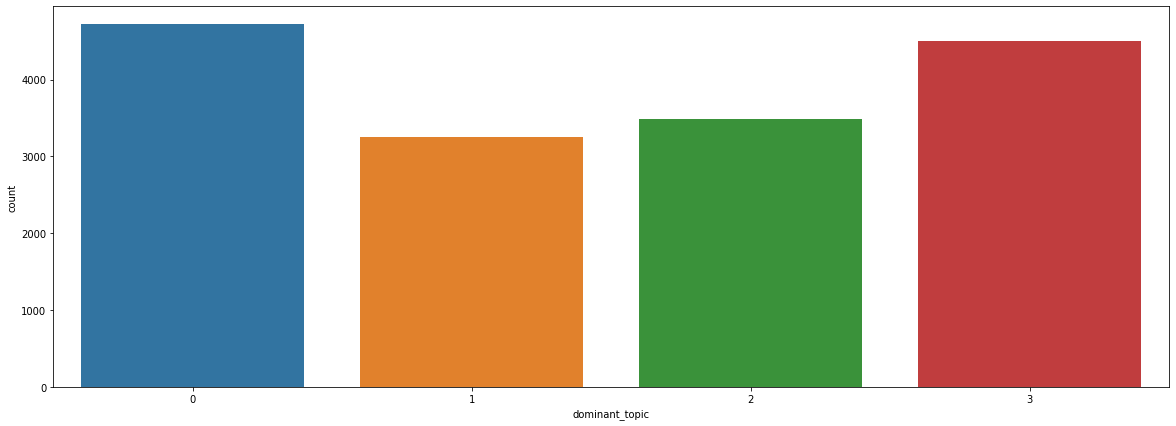

In [ ]:
# LDA
topicnames = ['Topic_' + str(i) for i in range(lda.n_components)]

docnames = ['Doc_' + str(i) for i in range(len(reviews))]

df_document_topic = pd.DataFrame(np.round(lda_vecs,2), columns=topicnames, index=docnames)

df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)
df_document_topic.head()

sns.countplot(df_document_topic.dominant_topic)

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

dtm = np.matrix(cv_vecs)
panel = pyLDAvis.sklearn.prepare(lda, dtm, cv, mds='tsne')
pyLDAvis.display(panel)

## Cosine Similarity




In [ ]:
# Take the average cosine similarity for for each type of vector

count_sims = cosine_similarity(cv_vecs)
tfidf_sims = cosine_similarity(tfidf_vecs)
nmf_sims = cosine_similarity(nmf_vecs)
lda_sims = cosine_similarity(lda_vecs)

In [ ]:
# Most similar review
all_text = list(reviews)

def most_similar_review(model_sims):
  random_idx = np.random.randint(len(all_text))
  print(all_text[random_idx]+'\n'+
      all_text[model_sims[random_idx].argsort()[::-1][:2][1]])

In [ ]:
# Most similar review using NMF with simple tokenizer
most_similar_review(lda_sims)

"I&#039;ve been battling high blood pressure for 30  years and this medicine combined with Carvedilol seems to be working the best for me thus far. It&#039;s taken approximately 3 months in order to get the blood pressure under control. I was running around 180/90 and now measure 120/60 average. If you start this medicine be patient and give it time to work. I&#039;ve experienced virtually no side effects so far....knock on wood."
"(2/2) from 0.6 to 1.2 I know my digestive system has slowed way down My doctor prescribed Metonia and Domperidone to counteract these side effects which seems to be working for me  I also notice my appetite has continued to be low and I get full very quickly my blood sugar stabilized with 3-4 day after starting the Victoza and despite the side effects I am happy with this medication but hope not to be on it long term as I worry about long term side effects I would recommend this"


In [ ]:
first_neg = len(reviews_pos)
  
def avg_cosine_similarity(sims_matrix):
  print('pos-to-pos:', sims_matrix[:first_neg, :first_neg].mean(axis=1).mean(),'\n'
        'pos-to-neg:', sims_matrix[:first_neg, first_neg:].mean(axis=1).mean(),'\n'
        'neg-to-neg:', sims_matrix[first_neg:, first_neg:].mean(axis=1).mean(),'\n')

In [ ]:
print('Average Cosine Similarity using Counts:')
avg_cosine_similarity(count_sims)
print('\n')

print('Average Cosine Similarity using TF-IDF:')
avg_cosine_similarity(tfidf_sims)
print('\n')

print('Average Cosine Similarity using NMF:')
avg_cosine_similarity(nmf_sims)
print('\n')

print('Average Cosine Similarity using LDA:')
avg_cosine_similarity(lda_sims)
print('\n')

Average Cosine Similarity using Counts:
pos-to-pos: 0.03227800949140951 
pos-to-neg: 0.02558259986034973 
neg-to-neg: 0.027068882014788787 



Average Cosine Similarity using TF-IDF:
pos-to-pos: 0.01780512318166461 
pos-to-neg: 0.01413496641638943 
neg-to-neg: 0.015573363626237556 



Average Cosine Similarity using NMF:
pos-to-pos: 0.4906255154542053 
pos-to-neg: 0.5104528662309917 
neg-to-neg: 0.5558269225964763 



Average Cosine Similarity using LDA:
pos-to-pos: 0.38758857400731633 
pos-to-neg: 0.37363811685649256 
neg-to-neg: 0.43014802446566947 





Counts and TF-IDF do a better job at seperating reviews from the two classes

## Split data into Train, Validation and Test set

In [ ]:
# Set train and validation percentages
pct_train = 0.8
pct_val = 0.3
np.random.seed(123)

# Split data into train and test
train_bool = np.random.random(len(data_subset)) <= pct_train
train = data_subset[train_bool]
test = data_subset[~train_bool]

# Split Train into train and validation 
val_bool = np.random.random(size=len(train)) <= pct_val
val = train[val_bool]
train = train[~val_bool]

print("Train Size:      ", train.shape)
print("Validation size: ", val.shape)
print("Test size:       ", test.shape)

Train Size:       (8965, 6)
Validation size:  (3841, 6)
Test size:        (3159, 6)


## GolVe Embedding (Document-Level Average)

### Load GloVe vectors text file

In [ ]:
# Unzip the file containing the GloVe vectors
!unzip "/content/Sentiment-Analysis-of-Drug-Reviews/Data Files/glove.6B.200d.txt.zip" -d "/content/Sentiment-Analysis-of-Drug-Reviews/Data Files"

Archive:  /content/Sentiment-Analysis-of-Drug-Reviews/Data Files/glove.6B.200d.txt.zip
  inflating: /content/Sentiment-Analysis-of-Drug-Reviews/Data Files/glove.6B.200d.txt  


In [ ]:
# Load the text file containing the words and its GloVe vectors to a dictionary 
glove_embedding_dict={}
with open(file_path + '/glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:])
        glove_embedding_dict[word]=vectors
f.close()

# Number of words present in the dictionary
print(len(glove_embedding_dict))

151503


### Obtain GloVe vectors

In [ ]:
# Function to take the doc-level average of the glove vectors
def glove_embedding_doc_level(data):
  doc_level_embedding = pd.DataFrame()
  # Tokenize each text in the data
  for doc in data.review:
    parsed = adv_tokenizer(doc)
    word_id = 0
    word_embeddings = np.zeros(shape=(len(doc), 200))
    # Get the word embedding for each word from the dictionary above
    for word in parsed:
      word_embeddings[word_id] = glove_embedding_dict.get(word)
      word_id=+1
    # Take the mean of each dimension (column) which gives the doc-level average
    doc_level_embedding = doc_level_embedding.append(pd.DataFrame(word_embeddings).mean(axis=0), ignore_index=True)

  print(doc_level_embedding.shape)
  return doc_level_embedding

In [ ]:
glove_train = glove_embedding_doc_level(train)
glove_val = glove_embedding_doc_level(val)
glove_test = glove_embedding_doc_level(test)

(8965, 200)
(3841, 200)
(3159, 200)


In [ ]:
# Save the vectors for future use
# glove_train.to_pickle('glove_train.pkl')
# glove_val.to_pickle('glove_val.pkl')
# glove_test.to_pickle('glove_test.pkl')

### Plot GloVe vectors

Plotting the GloVe vectors to see if there are any visible clusters.

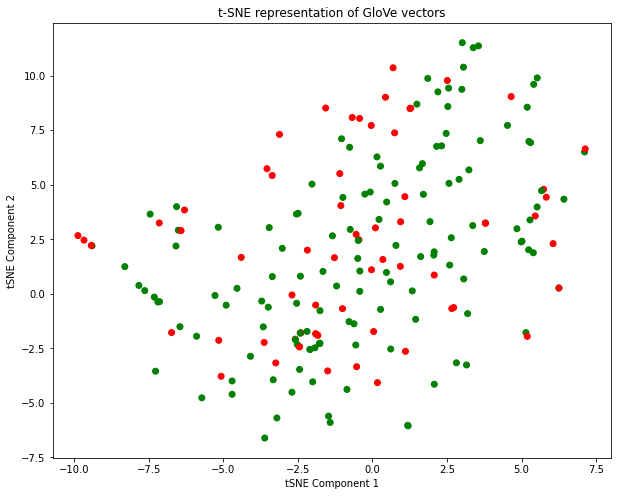

In [ ]:
rcParams['figure.figsize'] = 10, 8

N = 200

# Take the first 200 vectors
labels = train["sentiment"].apply(lambda sent: True if  sent == 'positive' 
                                         else False)

label = labels[0:N]
vectors = glove_train[:N]
colors = ['red','green']

# Initialise TSNE
tsne = TSNE(n_components=2)
# Reduce to two dimensions
Y = tsne.fit_transform(vectors)

# Plot seed words
plt.scatter(Y[:, 0], Y[:, 1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.title('t-SNE representation of GloVe vectors')

plt.show()

Unfortunetly this did not provide us with any good information.

## ElMo (Document-Level Average)

We tried implementing ELMo and it worked fine on small data but when we ran it on our reduced datatset, it did not stop running and we ran it for more than 2 hours. Hence, we omitted this from our project due to lack of computational power.

Unfortuntely, we could not code it in such a way it uses the GPU.

In [ ]:
# elmo = ElmoEmbedder()

In [ ]:
# def elmo_embedding_doc_level(data):
#   # Tokenize each document
#   token_docs = [adv_tokenizer(d) for d in data.review]
  
#   # Get ELMo embeddings of each word in each tokenized document
#   # [-1] -> To get the last set of ELMo embeddings
#   elmo_vecs = [elmo.embed_sentence(d)[-1] for d in token_docs]

#   # Take the mean of each dimension (column) which gives the doc-level average
#   doc_level_embedding = [word_vectors.mean(axis=0) for word_vectors in elmo_vecs]
#   # Convert to Df
#   doc_level_embedding = pd.DataFrame(doc_level_embedding)
#   print(doc_level_embedding.shape)
#   return doc_level_embedding

In [ ]:
# elmo_train = elmo_embedding_doc_level(train)
# elmo_val = elmo_embedding_doc_level(val)
# elmo_test = elmo_embedding_doc_level(test)

In [ ]:
# rcParams['figure.figsize'] = 10, 8

# N = 200

# # Take the first 200 vectors
# labels = train["sentiment"].apply(lambda sent: True if  sent == 'positive' 
#                                          else False)

# label = labels[0:N]
# vectors = elmo_train[:N]
# colors = ['red','green']

# # Initialise TSNE
# tsne = TSNE(n_components=2)
# # Reduce to two dimensions
# Y = tsne.fit_transform(vectors)

# # Plot seed words
# plt.scatter(Y[:, 0], Y[:, 1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

# plt.xlabel('tSNE Component 1')
# plt.ylabel('tSNE Component 2')
# plt.title('t-SNE representation of ELMo vectors')

# plt.show()

## DistilBERT (Document-Level Representation)

Due to the domain-specific nature of our dataset, it does not really make sense to use embedding methods like GloVe which has the vectors for only a general corpus, with neither context nor domain knowledge.

We wanted to tackle the issue of 'no context', using the famous DistilBERT model. 


In [ ]:
# basic pretrained model (case-insensitive)
MODEL_NAME = 'distilbert-base-uncased'
# Load pre-trained model
model = DistilBertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Delete variables that are no longer needed to save RAM
import gc
del train_data, test_data, data, data_subset
gc.collect()

1125

The GPU kept crashing even when ran BERT on our coprus

So we had to reduce two things to ensure it runs smoothly: Batch size, and Maximum length of each review.

After running multiple iterations and trying different conbinations, this is the only one that worked. And anything above this, crashed the system.
1. Batch size = 5
2. Maximum lenght of each review = 200

We do lose some information when we truncate the reviews to 200, but since majority of the reviews have around 250 tokens, the loss is not too much.


In [ ]:
def bert_embedding_doc_level(data):
  st = 0

  # batch-wise, otherwise tends to take a long time
  batch_size = 5
  batches = list(range(100, len(data), batch_size))+[len(data)]
  doc_rep_collector = []
  for b in batches:
      tokens = tokenizer.batch_encode_plus(data['review'][st:b], 
                                           pad_to_max_length=True, max_length=200, truncation=True, 
                                           return_tensors="pt")
            
      st = b
      tokens = tokens.to(device)
      model.to(device)
      outputs = model(**tokens)
      # taking the representation of the 'CLS' token (doc-level embedding)
      doc_rep_collector.append(outputs[0][:,0].detach().cpu().numpy())
  doc_rep_collector = np.concatenate(doc_rep_collector)
  return doc_rep_collector

In [ ]:
bert_train = bert_embedding_doc_level(train)
bert_val = bert_embedding_doc_level(val)
bert_test = bert_embedding_doc_level(test)

print(bert_train.shape)
print(bert_val.shape)
print(bert_test.shape)

(8965, 768)
(3841, 768)
(3159, 768)


In [ ]:
## Save the BERT vectors for future use
# np.save('bert_train_maxlen_200', bert_train)
# np.save('bert_val_maxlen_200', bert_val)
# np.save('bert_test_maxlen_200', bert_test)

In [ ]:
# Delete the created variables to save GPU
import gc
del bert_embedding_doc_level, model, tokenizer
gc.collect()

103

In [ ]:
# # Check available GPU
# torch.cuda.memory_summary(device=device, abbreviated=True)

## BioBERT (Document-Level Representation)

Now that we tried the BERT model which is great at including the context of the word while embedding it, we wanted to go a step further and include some domain knowledge as well i.e. biomedical terms. 

Cue in 'BioBERT'!

It is very similar to BERT, but as you might have guessed, this is used specifically for biomedical data which is exactly what we were looking for. BioBERT  is  the  first  domain-specific  BERT  based  model  pre-trained  on  biomedical  corpora  for  23  days  on  eight  NVIDIAV100 GPUs. Though it's mainly used for NER, Relation extraction and Question & Answering, it can be used for word embeddings as well.

The specific model that we are using is 'biobert_v1.1_pubmed' which has been train on Wikipedia, Books, and PubMed articles.

For more information, check out the [BioBERT paper](https://https://arxiv.org/ftp/arxiv/papers/1901/1901.08746.pdf) written by the researchers of Korea University & Clova AI research group based in Korea.

Note: Though the code is exactly the same as BERT, it took quite sometime to get hold of the models and understand how they work. This is mainly because BioBERT is not very widely used. 

In [ ]:
# BioBERT model
MODEL_NAME = 'monologg/biobert_v1.1_pubmed'

# Load pre-trained model
model = BertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Similar to BERT, BioBERT also crashed when we ran it on our dataset. Unfortunetly, BioBERT did not run with the same configurations as BERT. We had to reduce the batch size and maximum length even further.

This is the congiguration that worked,
1. Batch Size = 1
2. Maximum length = 125

We end up losing more information than we did with BERT. (This will be seen in the classification section.)

In [ ]:
def biobert_embedding_doc_level(data):
  st = 0
  # batch-wise, otherwise tends to take a long time
  batch_size = 1
  
  batches = list(range(100, len(data), batch_size))+[len(data)]
  doc_rep_collector = []
  for b in batches:
      tokens = tokenizer.batch_encode_plus(data['review'][st:b], 
                                           pad_to_max_length=True, max_length=125, truncation=True, 
                                           return_tensors="pt")
      st = b
      tokens = tokens.to(device)
      model.to(device)
      outputs = model(**tokens)
      # taking the representation of the 'CLS' token (doc-level embedding)
      doc_rep_collector.append(outputs[0][:,0].detach().cpu().numpy())
  doc_rep_collector = np.concatenate(doc_rep_collector)
  return doc_rep_collector

In [ ]:
# import gc
# del train_data, test_data, data, data_subset
# gc.collect()

381

In [ ]:
biobert_train = biobert_embedding_doc_level(train)
biobert_val = biobert_embedding_doc_level(val)
biobert_test = biobert_embedding_doc_level(test)

print(biobert_train.shape)
print(biobert_val.shape)
print(biobert_test.shape)

(8965, 768)
(3841, 768)
(3159, 768)


In [ ]:
# Save the vectors for future use
np.save('biobert_train_maxlen_125', biobert_train)
np.save('biobert_val_maxlen_125', biobert_val)
np.save('biobert_test_maxlen_125', biobert_test)

In [ ]:
# Delete the created variables to save GPU
import gc
del biobert_embedding_doc_level, model, tokenizer
gc.collect()

553

In [ ]:
# Check available RAM
torch.cuda.memory_summary(device=device, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |    9338 MB |    2148 GB |    2148 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |    9338 MB |    2148 GB |    2148 GB |\n|---------------------------------------------------------------------------|\n| GPU reserved memory   |    9628 MB |    9628 MB |    9628 MB |       0 B  |\n|--------------------------------------------------

## Load pre-trained Glove, BERT and BioBERT vectors

### NOTE: These files were created by **us** after training the models on our dataset. This is to avoid running above models every time to obtain the vectors.

Load these only if running in the whole dataset!

In [ ]:
# glove_train = pd.read_pickle(file_path+'glove_train.pkl')
# glove_val = pd.read_pickle(file_path+'glove_val.pkl')
# glove_test = pd.read_pickle(file_path+'glove_test.pkl')

In [ ]:
# bert_train = np.load(file_path+'bert_train_maxlen_200.npy')
# bert_val = np.load(file_path+'bert_val_maxlen_200.npy')
# bert_test = np.load(file_path+'bert_test_maxlen_200.npy')

In [ ]:
# biobert_train = np.load(file_path+'biobert_train_maxlen_125.npy')
# biobert_val = np.load(file_path+'biobert_val_maxlen_125.npy')
# biobert_test = np.load(file_path+'biobert_test_maxlen_125.npy')

## Sentiment Classification (EDIT)

Steps involved in classification are as follows:

1. Adding and Removing stopwords from the default stopwords list:
2. Handle the imbalance in the class labels.
3. Choose between spaCy's base English model and scispaCy's model.
4. Classification using Linear SVC, RBF SVC and Gaussian Naive Bayes (with train and validation data only)

Note: We implemented the above steps for all the types in embedding methods that we have done so far.

Finally, we run **only** the best model on the test data set to obtain the final accuracy.

### Classifier Function

In [ ]:
# Function to implement SVC and return desired metrics
def classifier_function(X_train, X_test, 
                        y_train = train["sentiment"], y_test=val["sentiment"], 
                        model_name=SVC, kernel='linear', weights='balanced',
                        confusionMatrix=False, prob=False):
  if model_name == SVC:
    model = model_name(kernel=kernel, class_weight=weights, probability=prob)
  else:
    model = model_name()
  model.fit(X_train, y_train)
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  # scoring accuracy
  print('Train accuracy :              ', round(accuracy_score(y_train, train_preds), 3))
  print('Validation accuracy :         ', round(accuracy_score(y_test, test_preds), 3))
  
  #Confusion matrix, Accuracy, sensitivity and specificity
  cm = confusion_matrix(y_test, test_preds)

  FP = cm[1,0]
  FN = cm[0,1]
  TP = cm[0,0]
  TN = cm[1,1]

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  print("Sensitivity :                 ", round(TPR, 3))
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  print("Specificity :                 ", round(TNR, 3))
  print('\n')

  if confusionMatrix:
    print('Confusion Matrix : \n', cm, '\n')
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print("Precision :                   ", round(PPV, 3))
    # Negative predictive value
    NPV = TN/(TN+FN)
    print("Negative Predictive Value :   ", round(NPV, 3))
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print("False Positive Rate :         ", round(FPR, 3))
    # False negative rate
    FNR = FN/(TP+FN)
    print("False Negative Rate :         ", round(FNR, 3))
    # False discovery rate
    FDR = FP/(TP+FP)
    print("False Discovery Rate :        ", round(FDR, 3))
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print("Overall Accuracy :            ", round(ACC, 3))
  return model

### Adding and Removing Stopwords

Though we implemented this already, it's better to make sure we haven't missed it as this is a big step for the classification.

In [ ]:
# # Facing an error with this

remove_stop_words = ["aren't","couldn't","didn't","doesn't","don't",
                    "hadn't","hasn't","haven't","isn't","mightn't",
                    "mustn't","needn't","shan't",
                    "shouldn't","wasn't","weren't","wouldn't"]

for word in remove_stop_words:
  if en.vocab[word].is_stop:
    en.Defaults.stop_words.remove(word)
    en.vocab[word].is_stop = False 

  if nlp_sci.vocab[word].is_stop:
    nlp_sci.Defaults.stop_words.remove(word)
    nlp_sci.vocab[word].is_stop = False  


In [ ]:
add_stop_words = ["feel", "feeling", "feels", 
                  "take", "takes","taking", "took", "taken",
                  "mg", "effect", "effects", 
                  "like", "liking", "likes",
                  "day", "week", "month", "year", "time",
                  "days", "weeks", "months", "years", "times",
                  "medication", "medicine", "medications", "medicines",
                  "start", "starting", "starts", "started",
                  "work", "works", "working",
                  "go", "going", "goes",
                  "blood", "pressure",
                  "bipolar", "disorder"]

for word in add_stop_words:
    if not en.vocab[word].is_stop:
      en.Defaults.stop_words.add(word)
      en.vocab[word].is_stop = True 

    if nlp_sci.vocab[word].is_stop:
      nlp_sci.Defaults.stop_words.add(word)
      nlp_sci.vocab[word].is_stop = True  

### Handle Imbalance of the Sentiment Classes

Like we saw earlier in the EDA, the sentiment labels are highly imbalanced and this is something that should be taken care of to avoid any bias and give a more realistic accuracy. Also, it's more vital that the model classifies a negative review as negative, than the vice versa.  

We surely do not want someone taking a drug based on a review labelled as positive when in fact it's negative. There could be a lot of bad consequences.

We took just one eample to show you how we handled this issue.

In [ ]:
# Fit Count Vectorizer and TF-IDF models based on the chosen tokenization strategy
cv = CountVectorizer(tokenizer=adv_tokenizer)
cv_train = cv.fit_transform(train["review"])
cv_val = cv.transform(val["review"])

In [ ]:
print("Accuracy using Counts with Linear SVC model:")
cv_model_lin = classifier_function(cv_train, cv_val, weights=None, confusionMatrix=True)

Accuracy using Counts with Linear SVC model:
Train accuracy :               0.988
Validation accuracy :          0.862
Sensitivity :                  0.757
Specificity :                  0.908


Confusion Matrix : 
 [[ 879  282]
 [ 247 2433]] 

Precision :                    0.781
Negative Predictive Value :    0.896
False Positive Rate :          0.092
False Negative Rate :          0.243
False Discovery Rate :         0.219
Overall Accuracy :             0.862


As you can see, though the overall accuracy is high, the sensitivity/true negative rate is much lower than the specificity/true positive rate with a difference of 15%. This is obviously because of the imbalance. 

Like we mentioned earlier, this is not good! But fortuntely, the SVC model has a parameter called ***'class weights'*** which penalizes the majority class more than the minority class. And setting this parameter to 'balanced', the weights are chosen by the model automatically.

Let's run the above model again, but with 'balanced' class weights.

In [ ]:
print("Accuracy using Counts with Linear SVC model:")
cv_model_lin = classifier_function(cv_train, cv_val, weights='balanced', confusionMatrix=True)

Accuracy using Counts with Linear SVC model:
Train accuracy :               0.985
Validation accuracy :          0.863
Sensitivity :                  0.81
Specificity :                  0.885


Confusion Matrix : 
 [[ 940  221]
 [ 307 2373]] 

Precision :                    0.754
Negative Predictive Value :    0.915
False Positive Rate :          0.115
False Negative Rate :          0.19
False Discovery Rate :         0.246
Overall Accuracy :             0.863


Now this is much better! The true negative rate seems to still be lower than the true positive rate, but at least we can be sure that it's not because of the imbalance in the dataset. For rest of the modelling, we decided to go ahead with the class weights as balanced.

### Function to Initialize Vectors

In [ ]:
def intialize_vectorizers(spacy_model, replace_ents):
  # Count vectorizer
  cv = CountVectorizer(tokenizer=lambda text: adv_tokenizer(text, model=spacy_model, replace_entities=replace_ents))
  cv_train = cv.fit_transform(train["review"])
  cv_val = cv.transform(val["review"])

  # TF-IDF vectorizer
  tfidf = TfidfVectorizer(tokenizer=lambda text: adv_tokenizer(text, model=spacy_model, replace_entities=replace_ents))
  tfidf_train = tfidf.fit_transform(train["review"])
  tfidf_val = tfidf.transform(val["review"])

  n_components = 4

  # NMF
  nmf = NMF(n_components=n_components)
  nmf_train = nmf.fit_transform(tfidf_train)
  nmf_val = nmf.transform(tfidf_val)

  # LDA
  lda = LatentDirichletAllocation(n_components=n_components)
  lda_train = lda.fit_transform(cv_train)
  lda_val = lda.transform(cv_val)

  return cv_train, cv_val, tfidf_train, tfidf_val, nmf_train, nmf_val, lda_train, lda_val

### Choosing Spacy Model

We had to choose from three choices:

1. spaCy's Base English model
2. sciSpacy's Disease-Chemical interaction model without replacing entities.
3. sciSpacy's Disease-Chemical interaction model after replacing entities.

All three performed almost the same, the third one performing just a tab bit worse. But we still decided to go head with the sciSpacy's Disease-Chemical interaction model after replacing entities because replacing the entities significantly reduced the feature space to about 8000 from about 13,000 with the base english model to 8350 with not much of a drop in accuracy.

Below are the results for the same running them on 4 embedding types:

Using Spacy's Base English model and Linear SVC:

In [ ]:
cv_train, cv_val, tfidf_train, tfidf_val, nmf_train, nmf_val, lda_train, lda_val = intialize_vectorizers(en, replace_ents=False)

# Run all above models
print("Accuracy using Counts with Base English model:")
cv_model_en = classifier_function(cv_train, cv_val, model_name=SVC, kernel='linear')
print("Accuracy using TF-IDF with Base English model:")
tfidf_model_en = classifier_function(tfidf_train, tfidf_val, model_name=SVC, kernel='linear')
print("Accuracy using NMF with Base English model:")
nmf_model_en = classifier_function(nmf_train, nmf_val, model_name=SVC, kernel='linear')
print("Accuracy using LDA with Base English model:")
lda_model_en = classifier_function(lda_train, lda_val, model_name=SVC, kernel='linear')

Accuracy using Counts with Base English model:
Train accuracy: 0.985145739910314
Validation accuracy: 0.8498978897208985


Accuracy using TF-IDF with Base English model:
Train accuracy: 0.9331558295964125
Validation accuracy: 0.8464942137508509


Accuracy using NMF with Base English model:
Train accuracy: 0.703335201793722
Validation accuracy: 0.7066031313818925


Accuracy using LDA with Base English model:
Train accuracy: 0.703335201793722
Validation accuracy: 0.7066031313818925




Using Scispacy model with entities:

In [ ]:
cv_train, cv_val, tfidf_train, tfidf_val, nmf_train, nmf_val, lda_train, lda_val = intialize_vectorizers(nlp_sci, replace_ents=False)

# Run all above models
print("Accuracy using Counts with ScispaCy model without replacing entities:")
cv_model_sci_ent = classifier_function(cv_train, cv_val, model_name=SVC, kernel='linear')
print("Accuracy using TF-IDF with ScispaCy model without replacing entities:")
cv_model_sci_ent = classifier_function(tfidf_train, tfidf_val, model_name=SVC, kernel='linear')
print("Accuracy using NMF with ScispaCy model without replacing entities:")
cv_model_sci_ent = classifier_function(nmf_train, nmf_val, model_name=SVC, kernel='linear')
print("Accuracy using LDA with ScispaCy model without replacing entities:")
cv_model_sci_ent = classifier_function(lda_train, lda_val, model_name=SVC, kernel='linear')

Accuracy using Counts with ScispaCy model without replacing entities:
Train accuracy: 0.976457399103139
Validation accuracy: 0.8505786249149081


Accuracy using TF-IDF with ScispaCy model without replacing entities:
Train accuracy: 0.9191423766816144
Validation accuracy: 0.8498978897208985


Accuracy using NMF with ScispaCy model without replacing entities:
Train accuracy: 0.703335201793722
Validation accuracy: 0.7066031313818925


Accuracy using LDA with ScispaCy model without replacing entities:
Train accuracy: 0.7550448430493274
Validation accuracy: 0.7620830496936691




Using Scispacy model replacing with entity type:

In [ ]:
cv_train, cv_val, tfidf_train, tfidf_val, nmf_train, nmf_val, lda_train, lda_val = intialize_vectorizers(nlp_sci, replace_ents=True)

# Run all above models
print("Accuracy using Counts with ScispaCy model after replacing entities:")
cv_model_sci = classifier_function(cv_train, cv_val, model_name=SVC, kernel='linear')
print("Accuracy using TF-IDF with ScispaCy model after replacing entities:")
tfidf_model_sci = classifier_function(tfidf_train, tfidf_val, model_name=SVC, kernel='linear')
print("Accuracy using NMF with ScispaCy model after replacing entities:")
nmf_model_sci = classifier_function(nmf_train, nmf_val, model_name=SVC, kernel='linear')
print("Accuracy using LDA with ScispaCy model after replacing entities:")
lda_model_sci = classifier_function(lda_train, lda_val, model_name=SVC, kernel='linear')

Accuracy using Counts with ScispaCy model after replacing entities:
Train accuracy: 0.9677690582959642
Validation accuracy: 0.8434309053778081


Accuracy using TF-IDF with ScispaCy model after replacing entities:
Train accuracy: 0.9119955156950673
Validation accuracy: 0.8519400953029271


Accuracy using NMF with ScispaCy model after replacing entities:
Train accuracy: 0.703335201793722
Validation accuracy: 0.7066031313818925


Accuracy using LDA with ScispaCy model after replacing entities:
Train accuracy: 0.703335201793722
Validation accuracy: 0.7066031313818925





### Classification Models 

1. Linear SVC
2. RBF SVC 
3. Naive Bayes

Note: Along with the train and validation accuracy, we've mentioned the sensitivity and specificity as well.

In [ ]:
# Initialize the counts and topic models
cv_train, cv_val, tfidf_train, tfidf_val, nmf_train, nmf_val, lda_train, lda_val = intialize_vectorizers(nlp_sci, replace_ents=True)

# Run all above models using Linear SVC

print("Accuracy using Counts with Linear SVC model:")
cv_model_lin = classifier_function(cv_train, cv_val, model_name=SVC, kernel='linear')

print("Accuracy using TF-IDF with Linear SVC model:")
tfidf_model_lin = classifier_function(tfidf_train, tfidf_val, model_name=SVC, kernel='linear')

print("Accuracy using NMF with Linear SVC model:")
nmf_model_lin = classifier_function(nmf_train, nmf_val, model_name=SVC, kernel='linear')

print("Accuracy using LDA with Linear SVC model:")
lda_model_lin = classifier_function(lda_train, lda_val, model_name=SVC, kernel='linear')

print("Accuracy using GloVe with Linear SVC model:")
glove_model_lin = classifier_function(glove_train, glove_val, model_name=SVC, kernel='linear')

# SVC using DistilBERT vectors
print("Accuracy using DistlBERT with Linear SVC model:")
distilbert_model_lin = classifier_function(bert_train, bert_val, model_name=SVC, kernel='linear')

# SVC using BioBERT vectors
print("Accuracy using BioBERT with Linear SVC model:")
biobert_model_lin = classifier_function(biobert_train, biobert_val, model_name=SVC, kernel='linear')

Accuracy using Counts with Linear SVC model:
Train accuracy :               0.964
Validation accuracy :          0.845
Sensitivity :                  0.803
Specificity :                  0.863


Accuracy using TF-IDF with Linear SVC model:
Train accuracy :               0.904
Validation accuracy :          0.816
Sensitivity :                  0.778
Specificity :                  0.833


Accuracy using NMF with Linear SVC model:
Train accuracy :               0.633
Validation accuracy :          0.628
Sensitivity :                  0.596
Specificity :                  0.641


Accuracy using LDA with Linear SVC model:
Train accuracy :               0.496
Validation accuracy :          0.487
Sensitivity :                  0.773
Specificity :                  0.363


Accuracy using GloVe with Linear SVC model:
Train accuracy :               0.704
Validation accuracy :          0.702
Sensitivity :                  0.025
Specificity :                  0.996


Accuracy using DistlBERT with Li

Counts and TF-IDF have performed pretty well with Counts having a validation accuracy of 86% but there seems to be quite a bit of over fitting, which we could expect because of the high dimensions.

Both NMF and LDA perform really poorliy with LDA having a validation accuracy of 48%!

GolVe seems to have a decent accuracy, but that's because it just labels everything as positive. Clearly GloVe does not seem to be able to distinguish between positive and negative reviews. 

DistilBERT and BioBERT seem to have comparable accuracies, with DistilBERT's being a little higher. We expected it to be the other way around but this could be becaus of the higher truncation we had to do for BioBERT. If they were trained on the same configurations, BioBERT could have actually performed better!

Also, BERT and BioBERT seem to have overfit very minimally!!



Radial Basis Function SVC:

In [ ]:
# Run all above models using RBF SVC

print("Accuracy using Counts with RBF SVC model:")
cv_model_rbf = classifier_function(cv_train, cv_val, model_name=SVC, kernel='rbf')

print("Accuracy using TF-IDF with RBF SVC model:")
tfidf_model_rbf = classifier_function(tfidf_train, tfidf_val, model_name=SVC, kernel='rbf')

print("Accuracy using NMF with RBF SVC model:")
nmf_model_rbf = classifier_function(nmf_train, nmf_val, model_name=SVC, kernel='rbf')

print("Accuracy using LDA with RBF SVC model:")
lda_model_rbf = classifier_function(lda_train, lda_val, model_name=SVC, kernel='rbf')

print("Accuracy using GloVe with RBF SVC model:")
glove_model_rbf = classifier_function(glove_train, glove_val, model_name=SVC, kernel='rbf')

# SVC using DistilBERT vectors
print("Accuracy using DistlBERT with RBF SVC model:")
distilbert_model_rbf = classifier_function(bert_train, bert_val, model_name=SVC, kernel='rbf')

# SVC using BioBERT vectors
print("Accuracy using BioBERT with RBF SVC model:")
biobert_model_rbf = classifier_function(biobert_train, biobert_val, model_name=SVC, kernel='rbf')

Accuracy using Counts with RBF SVC model:
Train accuracy :               0.934
Validation accuracy :          0.852
Sensitivity :                  0.82
Specificity :                  0.866


Accuracy using TF-IDF with RBF SVC model:
Train accuracy :               0.986
Validation accuracy :          0.88
Sensitivity :                  0.801
Specificity :                  0.915


Accuracy using NMF with RBF SVC model:
Train accuracy :               0.646
Validation accuracy :          0.637
Sensitivity :                  0.594
Specificity :                  0.656


Accuracy using LDA with RBF SVC model:
Train accuracy :               0.618
Validation accuracy :          0.609
Sensitivity :                  0.592
Specificity :                  0.616


Accuracy using GloVe with RBF SVC model:
Train accuracy :               0.733
Validation accuracy :          0.692
Sensitivity :                  0.439
Specificity :                  0.802


Accuracy using DistlBERT with RBF SVC model:
Trai

The results are almost similar except that TF-IDF and GloVe seem to have done a better job than last time!

But TF-IDF is still overfitting and GloVe still has a low sensitivity.

The accracies of DistilBERT and BioBERT seem to have deacreased a bit, suggesting that the relationship between the independent and dependent variables is more linear. Also, there is litereally no overfitting!

Gassian Naive Bayes:

In [ ]:
# Run all above models with Gaussian NB

print("Accuracy using Counts with Gaussian NB model:")
cv_model_nb = classifier_function(cv_train.toarray(), cv_val.toarray(), model_name=GaussianNB)

print("Accuracy using TF-IDF with Gaussian NB model:")
tfidf_model_nb = classifier_function(tfidf_train.toarray(), tfidf_val.toarray(), model_name=GaussianNB)

print("Accuracy using NMF with Gaussian NB model:")
nmf_model_nb = classifier_function(nmf_train, nmf_val, model_name=GaussianNB)

print("Accuracy using LDA with Gaussian NB model:")
lda_model_nb = classifier_function(lda_train, lda_val, model_name=GaussianNB)

print("Accuracy using GloVe with Gaussian NB model:")
glove_model_nb = classifier_function(glove_train, glove_val, model_name=GaussianNB)

# SVC using DistilBERT vectors
print("Accuracy using DistlBERT with Gaussian NB model:")
distilbert_model_nb = classifier_function(bert_train, bert_val, model_name=GaussianNB)

# SVC using BioBERT vectors
print("Accuracy using BioBERT with Gaussian NB model:")
biobert_model_nb = classifier_function(biobert_train, biobert_val, model_name=GaussianNB)

Accuracy using Counts with Gaussian NB model:
Train accuracy :               0.699
Validation accuracy :          0.582
Sensitivity :                  0.848
Specificity :                  0.466


Accuracy using TF-IDF with Gaussian NB model:
Train accuracy :               0.699
Validation accuracy :          0.583
Sensitivity :                  0.843
Specificity :                  0.471


Accuracy using NMF with Gaussian NB model:
Train accuracy :               0.704
Validation accuracy :          0.69
Sensitivity :                  0.197
Specificity :                  0.903


Accuracy using LDA with Gaussian NB model:
Train accuracy :               0.668
Validation accuracy :          0.666
Sensitivity :                  0.188
Specificity :                  0.874


Accuracy using GloVe with Gaussian NB model:
Train accuracy :               0.683
Validation accuracy :          0.681
Sensitivity :                  0.156
Specificity :                  0.908


Accuracy using DistlBERT wit

The results are far worse than the above two models. This could be attributed to the imbalance in classes and Naive Bayes is not the best suited when you have such issues.

One thing to note is that in this case, NMF, LDA and GLoVe have performed almost the same with a very low sensitivity.

### Final Test Accuracy of the Best Model

Based on the above results, it mainly comes down to:
1. Counts with Linear SVC 
2. TFIDF with RBF SVC
3. DistilBERT with Linear SVC
4. DistlBERT with RBF SVC model

The first two perform well on the train set but seem to overfit because of the lower validation accuracy.

DistlBERT with the RBF SVC model does not produce great results but does not overfit.

But, we decided to go with the DistilBERT model with Linear SVC because it gives pretty good results with very little overfitting.

In [ ]:
# SVC using DistilBERT vectors
print("Accuracy using DistlBERT with Linear SVC model:")
distilbert_model_lin = classifier_function(bert_train, bert_val, model_name=SVC, kernel='linear', prob=True)

Accuracy using DistlBERT with Linear SVC model:
Train accuracy :               0.854
Validation accuracy :          0.829
Sensitivity :                  0.825
Specificity :                  0.831




In [ ]:
model = distilbert_model_lin
X_test = bert_test
y_test = test["sentiment"]

test_preds = model.predict(X_test)

print('Test Accuracy :   ', round(accuracy_score(y_test, test_preds), 3))

#Confusion matrix, Accuracy, sensitivity and specificity
cm_test = confusion_matrix(y_test, test_preds)

FP = cm_test[1,0]
FN = cm_test[0,1]
TP = cm_test[0,0]
TN = cm_test[1,1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity :     ", round(TPR, 3))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity :     ", round(TNR, 3))

Test Accuracy:    0.812
Sensitivity :     0.8
Specificity :     0.817


In [ ]:
# pickle.dump(distilbert_model_lin, open('model.pkl', 'wb'))

## Future Work

1. Try using more advanced embedding techniques like RoBERTa or XLNet .
2. At first, we wanted to try the LSTM model for classification so we could give that a run.
3. Use different strategies for extracting important characteristics of each drug.